### NYT COVID
https://github.com/nytimes/covid-19-data

### Download selected data and create graphs

In [1]:
using CSV, DataFrames, Plots, Dates, Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-7649771135552871536\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-745533577652485131\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-7649771135552871536\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
gr()
#plotly()

Plots.GRBackend()

### Utilities

In [3]:
function percent_change(df, field, day_idx=0, offset=7) 
    ## Assumes df selected for state or state/county
    ## day_idx is most current day
    r,_ = size(df)
    r > offset + day_idx || return(NaN)
    a,b = df[!,field][[end - day_idx - offset, end - day_idx]]
    (b/a -1) *100
end

percent_change (generic function with 3 methods)

In [4]:
function percent_change_2(df, day::Date, delta::Integer)
    d2 = day
    d1 = day - Dates.Day(delta)
    a,b=filter(r-> r.date == d2 || r.date == d1 ,[:date, field])[:,2]
    return (b/a -1) *100
end

percent_change_2 (generic function with 1 method)

In [5]:
function moving_avg(col, days)
    total = copy(col)
    days <= length(col) + 1 || (total = NaN; return(total))
    for i in 1:days-1
        new = col[1:i]
        append!(new,col[1:end-i])
        total = total .+ new
    end
    total./days
end

moving_avg (generic function with 1 method)

In [6]:
function get_state_populations()
    url = "https://raw.githubusercontent.com/prairie-guy/2019-State-and-County-Population-with-FIPS-key/master/2019_state_populations.csv"
    CSV.read(download(url),type=String,types=Dict(3=>Int64))
end

get_state_populations (generic function with 1 method)

In [7]:
function get_county_populations()
    url = "https://raw.githubusercontent.com/prairie-guy/2019-State-and-County-Population-with-FIPS-key/master/2019_county_populations.csv"
    CSV.read(download(url),type=String,types=Dict(4=>Int64))
end

get_county_populations (generic function with 1 method)

In [8]:
function augment_cols!(df,days_ma=7) # Assumes {:cases, :deaths} exist
    df[:,:casesIncrease]   .= append!([0],df.cases[2:end] - df.cases[1:end-1])
    df[:,:deathsIncrease]  .= append!([0],df.deaths[2:end] - df.deaths[1:end-1])
    df[:,:casesMA]         .= moving_avg(df.cases,days_ma)
    df[:,:deathsMA]        .= moving_avg(df.deaths,days_ma)
    df[:,:casesIncreaseMA] .= moving_avg(df.casesIncrease,days_ma)
    df[:,:deathsIncreaseMA].= moving_avg(df.deathsIncrease,days_ma)
    df
end

augment_cols! (generic function with 2 methods)

### Get NYT County COVID Data       

All data for NYT is ordered from earliest to lastest date

In [9]:
function get_nyt_county_covid_data(ma_days=14) # All states
    url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
    df = CSV.read(download(url),silencewarnings=true,types=Dict(4=>String))
    df = sort(df)
    df[!,:casesIncrease]   .= 0
    df[!,:deathsIncrease]  .= 0
    df[!,:casesMA]         .= 0.0
    df[!,:deathsMA]        .= 0.0
    df[!,:casesIncreaseMA] .= 0.0
    df[!,:deathsIncreaseMA].= 0.0
    for r in groupby(df,[:state,:county])
        augment_cols!(r,ma_days)
        #println("$(r.date)\t$(r.state)\t$(r.county)\t$(r.cases)\t$(r.casesIncrease)\t$(r.casesIncreaseMA)")
    end
    df
end 

get_nyt_county_covid_data (generic function with 2 methods)

#### Download the NYT COVID Data for each County

Use a 7 day moving average for Case Increases and Death Increases

In [10]:
dfc = get_nyt_county_covid_data(7); # 7-day moving average covers a weekly cycle

In [11]:
first(dfc,10)

,date,county,state,fips,cases,deaths,casesIncrease,deathsIncrease
,Date,String,String,String?,Int64,Int64,Int64,Int64
1,2020-01-21,Snohomish,Washington,53061,1,0,0,0
2,2020-01-22,Snohomish,Washington,53061,1,0,0,0
3,2020-01-23,Snohomish,Washington,53061,1,0,0,0
4,2020-01-24,Cook,Illinois,17031,1,0,0,0
5,2020-01-24,Snohomish,Washington,53061,1,0,0,0
6,2020-01-25,Cook,Illinois,17031,1,0,0,0
7,2020-01-25,Orange,California,06059,1,0,0,0
8,2020-01-25,Snohomish,Washington,53061,1,0,0,0
9,2020-01-26,Cook,Illinois,17031,1,0,0,0


In [12]:
names(dfc)

12-element Array{String,1}:
 "date"
 "county"
 "state"
 "fips"
 "cases"
 "deaths"
 "casesIncrease"
 "deathsIncrease"
 "casesMA"
 "deathsMA"
 "casesIncreaseMA"
 "deathsIncreaseMA"

#### Use innerjoin on $fips$ to include county popluation from Census data

In [13]:
pops = get_county_populations()
first(pops,5)

,fips,state,county,population
,String,String,String,Int64
1,01001,Alabama,Autauga County,55869
2,01003,Alabama,Baldwin County,223234
3,01005,Alabama,Barbour County,24686
4,01007,Alabama,Bibb County,22394
5,01009,Alabama,Blount County,57826


In [14]:
df_fips = DataFrame(fips=pops.fips,population=pops.population)
first(df_fips,5)

,fips,population
,String,Int64
1,01001,55869
2,01003,223234
3,01005,24686
4,01007,22394
5,01009,57826


In [15]:
dfc = leftjoin(dfc,df_fips, on="fips")
first(dfc,5)

,date,county,state,fips,cases,deaths,casesIncrease,deathsIncrease
,Date,String,String,String?,Int64,Int64,Int64,Int64
1,2020-01-21,Snohomish,Washington,53061,1,0,0,0
2,2020-01-22,Snohomish,Washington,53061,1,0,0,0
3,2020-01-23,Snohomish,Washington,53061,1,0,0,0
4,2020-01-24,Cook,Illinois,17031,1,0,0,0
5,2020-01-24,Snohomish,Washington,53061,1,0,0,0


In [16]:
names(dfc)

13-element Array{String,1}:
 "date"
 "county"
 "state"
 "fips"
 "cases"
 "deaths"
 "casesIncrease"
 "deathsIncrease"
 "casesMA"
 "deathsMA"
 "casesIncreaseMA"
 "deathsIncreaseMA"
 "population"

#### Select data for a specific $State$ and $County$

In [17]:
select_region(dfc,state::String,county::String) = filter(r-> r.state .== state && r.county .== county, dfc)

select_region (generic function with 1 method)

In [18]:
select_region(dfc,"Illinois","Cook")

,date,county,state,fips,cases,deaths,casesIncrease,deathsIncrease
,Date,String,String,String?,Int64,Int64,Int64,Int64
1,2020-01-24,Cook,Illinois,17031,1,0,0,0
2,2020-01-25,Cook,Illinois,17031,1,0,0,0
3,2020-01-26,Cook,Illinois,17031,1,0,0,0
4,2020-01-27,Cook,Illinois,17031,1,0,0,0
5,2020-01-28,Cook,Illinois,17031,1,0,0,0
6,2020-01-29,Cook,Illinois,17031,1,0,0,0
7,2020-01-30,Cook,Illinois,17031,2,0,1,0
8,2020-01-31,Cook,Illinois,17031,2,0,0,0
9,2020-02-01,Cook,Illinois,17031,2,0,0,0


In [19]:
cnty = "Cook"
st   = "Illinois"
for r in eachrow(select_region(dfc,st,cnty))
    println("$(r.date)\t$(r.fips)\t$(r.cases)\t$(r.casesIncrease)\t$(r.casesIncreaseMA)")
end

2020-01-24	17031	1	0	0.0
2020-01-25	17031	1	0	0.0
2020-01-26	17031	1	0	0.0
2020-01-27	17031	1	0	0.0
2020-01-28	17031	1	0	0.0
2020-01-29	17031	1	0	0.0
2020-01-30	17031	2	1	0.14285714285714285
2020-01-31	17031	2	0	0.14285714285714285
2020-02-01	17031	2	0	0.14285714285714285
2020-02-02	17031	2	0	0.14285714285714285
2020-02-03	17031	2	0	0.14285714285714285
2020-02-04	17031	2	0	0.14285714285714285
2020-02-05	17031	2	0	0.14285714285714285
2020-02-06	17031	2	0	0.0
2020-02-07	17031	2	0	0.0
2020-02-08	17031	2	0	0.0
2020-02-09	17031	2	0	0.0
2020-02-10	17031	2	0	0.0
2020-02-11	17031	2	0	0.0
2020-02-12	17031	2	0	0.0
2020-02-13	17031	2	0	0.0
2020-02-14	17031	2	0	0.0
2020-02-15	17031	2	0	0.0
2020-02-16	17031	2	0	0.0
2020-02-17	17031	2	0	0.0
2020-02-18	17031	2	0	0.0
2020-02-19	17031	2	0	0.0
2020-02-20	17031	2	0	0.0
2020-02-21	17031	2	0	0.0
2020-02-22	17031	2	0	0.0
2020-02-23	17031	2	0	0.0
2020-02-24	17031	2	0	0.0
2020-02-25	17031	2	0	0.0
2020-02-26	17031	2	0	0.0
2020-02-27	17031	2	0	0.0
2020-02-28	17

In [20]:
round(100*percent_change(select_region(dfc,"Illinois","Cook"),:casesIncreaseMA,0,7))

93.0

In [21]:
round(100*percent_change(select_region(dfc,"Minnesota","St. Louis"),:casesIncreaseMA,0,7))

4000.0

## Percentage Change in New Daily Cases By County

In [22]:
function percent_change_cases_by_county(df_region, day_index=0,delta=14)
    state, county, pop, cases, casesIncMA, pch_casesIncMA, = [],[],[],[],[],[]
    for g in groupby(df_region,[:state,:county])
        nrow(g) - day_index < 1 ? break :    
            push!(state, g[1,:state])
            push!(county,g[1,:county])
            push!(pop,   g[1,:population])
            push!(cases, g[end - day_index,:cases]) 
            push!(casesIncMA, round(g[end - day_index,:casesIncreaseMA]))
            push!(pch_casesIncMA, round(percent_change(g,:casesIncreaseMA,day_index,delta)))
    end
    sort(DataFrame(state=state,county=county,pop=pop,cases=cases,
                   casesIncMA=casesIncMA,pch_casesIncMA=pch_casesIncMA),
        [:state,:county])
end   

percent_change_cases_by_county (generic function with 3 methods)

#### Week-over-week-growth using 7 day moving average

In [23]:
dfcd = percent_change_cases_by_county(dfc,0,7) # dfc -> dfcd (df_county_delta)
first(dfcd,5)

,state,county,pop,cases,casesIncMA,pch_casesIncMA
,Any,Any,Any,Any,Any,Any
1,Alabama,Autauga,55869,136,6.0,23.0
2,Alabama,Baldwin,223234,270,6.0,11.0
3,Alabama,Barbour,24686,96,4.0,23.0
4,Alabama,Bibb,22394,52,1.0,100.0
5,Alabama,Blount,57826,47,0.0,-33.0


In [24]:
min_cases = 1000

1000

In [25]:
dfcd_f = filter(r-> !isnan(r.pch_casesIncMA) && r.cases > min_cases,dfcd);

In [26]:
println("(%)Inc\tCases\tPop\tState, County")
println()
for c in eachrow(sort(dfcd_f,[:pch_casesIncMA],rev=true))
    println("$(c.pch_casesIncMA)\t$(c.cases)\t$(c.pop)\t$(c.county), $(c.state)")
end

(%)Inc	Cases	Pop	State, County

361.0	3320	missing	Unknown, Michigan
176.0	3213	440059	East Baton Rouge, Louisiana
101.0	1846	550321	Ramsey, Minnesota
91.0	1053	158167	Johnson, Indiana
77.0	1915	405813	Genesee, Michigan
76.0	1386	720403	El Paso, Colorado
76.0	5531	945726	Milwaukee, Wisconsin
75.0	1131	321488	Durham, North Carolina
72.0	2196	117415	Potter, Texas
68.0	2540	65093	Marion, Ohio
67.0	1707	1393452	Orange, Florida
66.0	2466	741770	Monroe, New York
63.0	2780	1110356	Mecklenburg, North Carolina
61.0	2322	2003554	Bexar, Texas
60.0	1012	181215	Imperial, California
59.0	1307	1111761	Wake, North Carolina
57.0	1305	471519	Washoe, Nevada
55.0	1433	658573	Jefferson, Alabama
52.0	2432	missing	Unknown, Georgia
49.0	2866	missing	Unknown, Puerto Rico
46.0	1115	196311	Racine, Wisconsin
44.0	1254	1552058	Sacramento, California
43.0	16033	2716940	Miami-Dade, Florida
43.0	2637	250873	Yakima, Washington
42.0	1113	379299	Allen, Indiana
42.0	5838	1265843	Hennepin, Minnesota
41.0	1930	839238	El Pa

In [27]:
num_c =nrow(dfcd_f)

216

In [28]:
round(100*count(dfcd_f.pch_casesIncMA .> 0)/num_c)

44.0

In [29]:
round(100*count(dfcd_f.pch_casesIncMA .< 0)/num_c)

55.0

## Change County in Growth Rates over time

In [30]:
min_cases = 500
days_ma = 7
min_grw = 10

10

In [31]:
@manipulate for day_idx in 0:50  
    dfcd = percent_change_cases_by_county(dfc,day_idx,7)
    dfcd_f = filter(r-> !isnan(r.pch_casesIncMA) && r.cases > min_cases,dfcd)
    num_c =nrow(dfcd_f)
    
    inc_ma = round(100*count(dfcd_f.pch_casesIncMA .> min_grw)/num_c)
    dec_ma = round(100*count(dfcd_f.pch_casesIncMA .< min_grw)/num_c)
    (inc_ma, dec_ma, num_c)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["day_idx"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 50,:min => 0,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
25, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/cdaniels/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/cdaniels/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/cdaniels/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/Users/cdaniels/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/Users/cdaniels/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000109a32f50, Task (runnable) @0x0000000109a32f50), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0\",\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\"

### County Infection Rate per 100,000

In [32]:
dfcp = percent_change_cases_by_county(dfc,0,7)
dfcp = [dfcp round.(100000 * dfcp.casesIncMA ./ dfcp.pop)]
rename!(dfcp,:x1=>:casesInc100k)
dfcp = dfcp[:,[:state,:county,:pop,:cases,:casesIncMA,:casesInc100k,:pch_casesIncMA]]
first(dfcp,5)

,state,county,pop,cases,casesIncMA,casesInc100k,pch_casesIncMA
,Any,Any,Any,Any,Any,Float64?,Any
1,Alabama,Autauga,55869,136,6.0,11.0,23.0
2,Alabama,Baldwin,223234,270,6.0,3.0,11.0
3,Alabama,Barbour,24686,96,4.0,16.0,23.0
4,Alabama,Bibb,22394,52,1.0,4.0,100.0
5,Alabama,Blount,57826,47,0.0,0.0,-33.0


#### Highest Number of New Daily Cases per County per 1000,000

In [33]:
sort(filter(r->!ismissing(r.casesInc100k)&& !isnan(r.casesInc100k),dfcp),[:casesInc100k],rev=true)

,state,county,pop,cases,casesIncMA,casesInc100k,pch_casesIncMA
,Any,Any,Any,Any,Any,Float64?,Any
1,Oklahoma,Texas,19983,791,45.0,225.0,58.0
2,Tennessee,Lake,7016,403,15.0,214.0,-57.0
3,Iowa,Crawford,16820,420,30.0,178.0,105.0
4,Georgia,Echols,4006,53,6.0,150.0,760.0
5,Nebraska,Colfax,10709,559,16.0,149.0,-27.0
6,Kansas,Finney,36467,1363,47.0,129.0,-17.0
7,Virginia,Richmond,9023,263,9.0,100.0,11.0
8,Texas,Potter,117415,2196,111.0,95.0,72.0
9,Nebraska,Dakota,20026,1576,18.0,90.0,-72.0


#### Highest Number of New Daily Cases per County

In [34]:
first(sort(filter(r->!ismissing(r.casesInc100k)&& !isnan(r.casesInc100k),dfcp),[:casesIncMA],rev=true),25)

,state,county,pop,cases,casesIncMA,casesInc100k,pch_casesIncMA
,Any,Any,Any,Any,Any,Float64?,Any
1,Illinois,Cook,5150233,66213,1401.0,27.0,1.0
2,California,Los Angeles,10039107,40857,918.0,9.0,11.0
3,Maryland,Prince George's,909327,12467,339.0,37.0,22.0
4,Minnesota,Hennepin,1265843,5838,258.0,20.0,42.0
5,Maryland,Montgomery,1050688,9093,253.0,24.0,18.0
6,Pennsylvania,Philadelphia,1584064,20359,226.0,14.0,-24.0
7,Florida,Miami-Dade,2716940,16033,224.0,8.0,43.0
8,Massachusetts,Worcester,830622,9780,220.0,26.0,23.0
9,Connecticut,Hartford,891720,9234,215.0,24.0,25.0


#### Highest Number of New Daily Cases per County by Population

In [35]:
first(sort(filter(r->!ismissing(r.casesInc100k)&& !isnan(r.casesInc100k),dfcp),[:pop],rev=true),50)

,state,county,pop,cases,casesIncMA,casesInc100k,pch_casesIncMA
,Any,Any,Any,Any,Any,Float64?,Any
1,California,Los Angeles,10039107,40857,918.0,9.0,11.0
2,Illinois,Cook,5150233,66213,1401.0,27.0,1.0
3,Texas,Harris,4713325,10095,211.0,4.0,7.0
4,Arizona,Maricopa,4485414,7644,186.0,4.0,8.0
5,California,San Diego,3338330,6203,123.0,4.0,-10.0
6,California,Orange,3175692,4746,129.0,4.0,13.0
7,Florida,Miami-Dade,2716940,16033,224.0,8.0,43.0
8,Texas,Dallas,2635516,7904,186.0,7.0,-25.0
9,California,Riverside,2470546,6184,120.0,5.0,25.0


### Epidemiological Curves

In [41]:
function graph_epidemiological_Curve(state, county)
    df = select_region(dfc,state,county)
    bar(df.date, df.casesIncrease)
    plot!(df.date, df.casesIncreaseMA,
    xticks=Date.(df.date)[1:14:end], xrotation=45,
    lw=2, color=:red,leg=:topleft)
    xlabel!("Date")
    ylabel!("New Cases")
    title!("New Daily Cases\n$(county), $(state)")   
end

graph_epidemiological_Curve (generic function with 1 method)

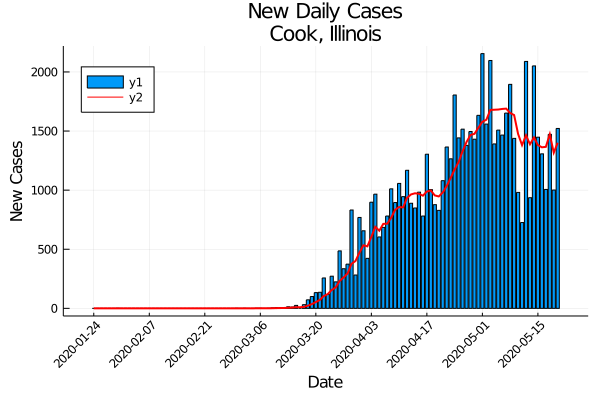

In [44]:
graph_epidemiological_Curve("Illinois","Cook")

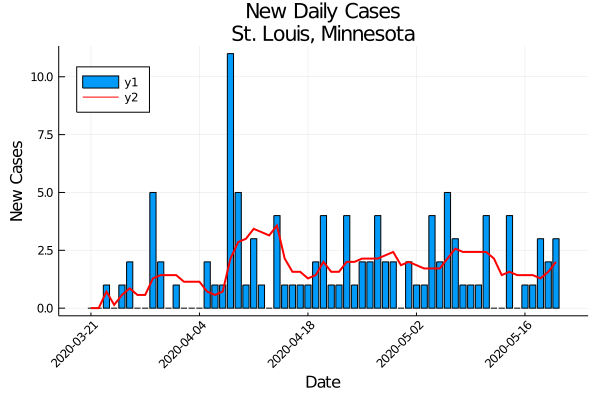

In [45]:
graph_epidemiological_Curve("Minnesota","St. Louis")

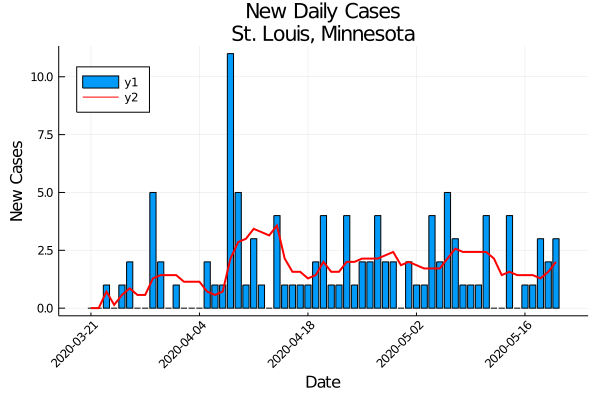

In [45]:
graph_epidemiological_Curve("Minnesota","St. Louis")